In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import netCDF4 as nc
import matplotlib.pyplot as plt

In [12]:
amoc=pd.read_csv('amoc_averaged.txt')
sst_annual = xr.open_dataset('tas_annual.nc')
st_annual = xr.open_dataset('ts_annual.nc')

'\nsns.lineplot(data=global_mean,x="Year",y="tas")\nplt.ylabel("Average temp 2M below")\nplt.title("Annual Average Temperatures 2M Below Sea Surface over 1000 Years")\nglobal_mean.head()\n#plt.show()\nplt.savefig("lineplot_tas.png")\n\nplt.figure()\nplt.hist(global_mean["tas"])\nplt.title("Distribution of Temperatures 2m Below Sea Surface")\nplt.xlabel("Average temp 2M below")\n#plt.show()\nplt.savefig("histplot_tas.png")\n'

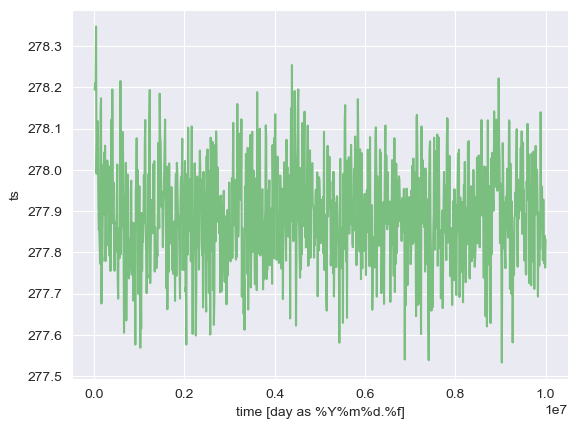

In [27]:
#global mean
global_mean = sst_annual.tas.mean(['lat','lon'])
st_mean = st_annual.ts.mean(['lat','lon'])
#change to years instead of time intervals
#global_mean['Year'] = list(range(0,999))
#st_mean['Year'] = list(range(0,999))
plt.figure()
sns.set_palette(['#7abe80'])
sns.set_style("darkgrid")
#global_mean.plot()
st_mean.plot()


'''
sns.lineplot(data=global_mean,x="Year",y="tas")
plt.ylabel("Average temp 2M below")
plt.title("Annual Average Temperatures 2M Below Sea Surface over 1000 Years")
global_mean.head()
#plt.show()
plt.savefig("lineplot_tas.png")

plt.figure()
plt.hist(global_mean["tas"])
plt.title("Distribution of Temperatures 2m Below Sea Surface")
plt.xlabel("Average temp 2M below")
#plt.show()
plt.savefig("histplot_tas.png")
'''

In [13]:
print(sst_n['tas'].unique())
print(np.min(sst_n['tas']))
print(sst_n['tas'].mode())
#sst_n.head()

[254.35176 260.13196 268.72482 ... 251.06987 241.5039  237.15872]
228.1768341064453
0    299.021423
1    299.992798
Name: tas, dtype: float32


In [15]:
print(sst_ocean['tas'].unique())
print(np.min(sst_ocean['tas']))
print(sst_ocean['tas'].mode())

[254.35176 260.13196 268.72482 ... 269.96362 267.30664 261.92664]
242.39865112304688
0    299.021423
1    299.503784
2    299.561523
3    299.987427
4    299.992798
Name: tas, dtype: float32


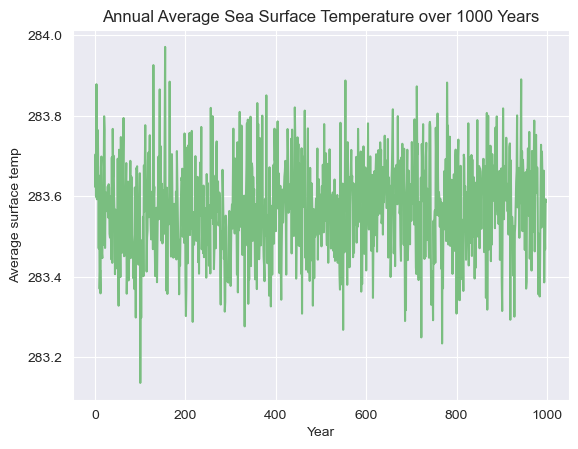

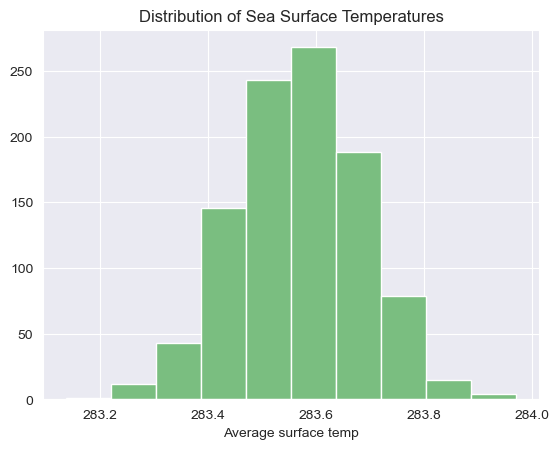

In [46]:
plt.figure()

sns.lineplot(data=st_mean,x="Year",y="ts")
plt.ylabel("Average surface temp")
plt.title("Annual Average Sea Surface Temperature over 1000 Years")
global_mean.head()
#plt.show()
plt.savefig("lineplot_ts.png")

plt.figure()
plt.hist(st_mean["ts"])
plt.title("Distribution of Sea Surface Temperatures")
plt.xlabel("Average surface temp")
#plt.show()
plt.savefig("histplot_ts.png")

In [28]:

n_years = 1000
months_per_year = 12
# Year column: 1001 to 2000, repeated 12 times each
amoc['Year'] = np.repeat(np.arange(1001, 2001), months_per_year)

# Month column: 1 to 12 repeated for each year
amoc['Month'] = np.tile(np.arange(1, 13), n_years)
amoc.head()

,AMOC index,Year,Month
0,17.5253,1001,1
1,18.9512,1001,2
2,19.4958,1001,3
3,19.3449,1001,4
4,18.8237,1001,5


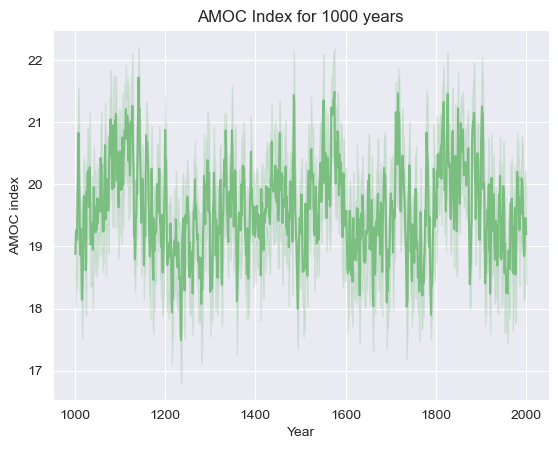

In [29]:
plt.figure()
sns.lineplot(data=amoc,x="Year",y="AMOC index")
plt.title("AMOC Index for 1000 years")
plt.savefig("simulation_transient.png")

In [30]:
#find mean and standard deviation for Amoc index

#put amoc values in arrays for handling
amoc_list = amoc['AMOC index'].tolist()
#find mean and standard deviation
control_mean = np.mean(amoc_list)
control_std_dev = np.std(amoc_list)
control_variance = np.var(amoc_list)
print('mean: ',control_mean,'standard deviation: ',control_std_dev,'variance: ',control_variance)

mean:  19.603801875 standard deviation:  1.424575297205212 variance:  2.0294147774073177


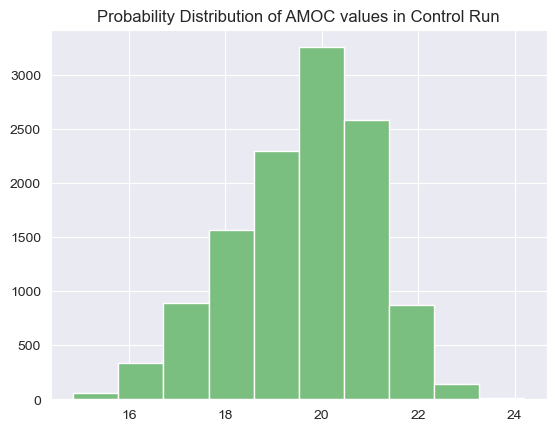

In [31]:
plt.hist(amoc_list)
plt.title('Probability Distribution of AMOC values in Control Run')
plt.savefig('control_hist.png')

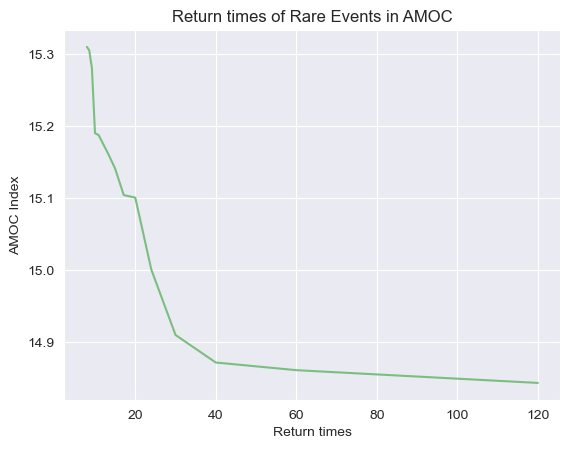

In [32]:
#return time function - calculate return time - probability that x is less than a for each a (need to calculate a)
delta_t=0.01
return_times = []
#decide on a - values below 3 std dev below mean
threshold_a = control_mean - 3*control_std_dev
a_list = []
#construct list of all a 
for val in sorted(amoc_list):
    if val<=threshold_a:
        a_list.append(val)
        
#find probability of x is less than a for all a, find return time
for val in range(1,len(a_list)+1):
    #number of values less is number that val is in the list
    prob_less = val/len(amoc_list)
    return_time = delta_t/prob_less
    return_times.append(return_time)

return_data = pd.DataFrame(data={'Return times':return_times,'AMOC Index':a_list})


sns.lineplot(data=return_data,x='Return times',y='AMOC Index').set_title('Return times of Rare Events in AMOC')
plt.savefig('returntimes_control.png')

In [57]:
#change list to temp and salt 
slices = np.array_split(amoc_list, 1500)
products = []
slice_length = len(amoc_list) // 1500
expectations = np.zeros((1500,slice_length))
for slice_num, slice in enumerate(slices):
    for i in range(len(slice)):
        expectations[slice_num,i] = (slice[0]-control_mean)*(slice[i]-control_mean)
    #print(slice[0],slice[i],control_mean**2)
#find mean of AC at each expected value of amoc
ACF_mean = np.mean(expectations, axis=0)
ACF = []

#divide by variance
for mean in ACF_mean:
    R_t = mean/control_variance
    ACF.append(R_t)

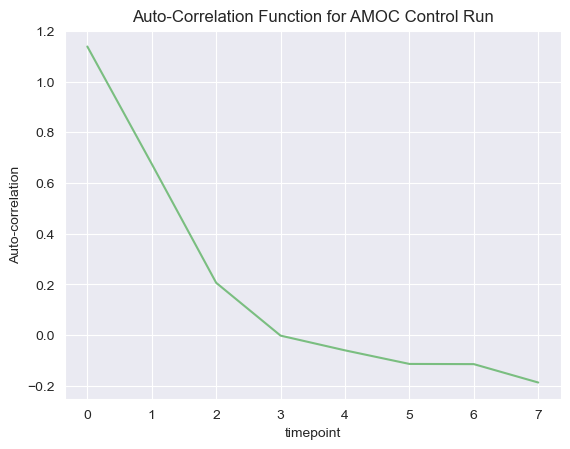

In [58]:
#plot autocorrelation function
plt.figure()
plt.plot(ACF)
plt.title('Auto-Correlation Function for AMOC Control Run')
plt.xlabel('timepoint')
plt.ylabel('Auto-correlation')
plt.savefig('acfunc_control.png')

In [59]:
#integral auto-correlation time (system memory), tau
mults=[]
for auto in range(len(ACF)):
    mults.append(ACF[auto]*delta_t)
tau = np.sum(mults)
print(tau)

0.015434209967016223


In [60]:
#compute k
print(control_variance)
a = control_mean - 3*control_std_dev
print(control_std_dev)
print(a)
k=a/(tau/control_variance)
print(k)
#target value of a where trajectory drops to
k=(-0.03)/tau/control_variance
#target value of a where edge state
k=(0.4)/tau/control_variance
print(k)

2.0294147774073177
1.424575297205212
15.330075983384363
2015.722398875186
12.77040788586255
